In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import PIL.ImageOps
import os
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
from scipy.spatial.distance import cosine
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [4]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [5]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

In [6]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self, index):
        try:
            img0_tuple = random.choice(self.imageFolderDataset.imgs)
            
            should_get_same_class = random.randint(0,1) 
            max_attempts = 100
            
            if should_get_same_class:
                attempts = 0
                while attempts < max_attempts:
                    img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if img0_tuple[1] == img1_tuple[1]:
                        break
                    attempts += 1
                if attempts == max_attempts:
                    img1_tuple = img0_tuple
            else:
                attempts = 0
                while attempts < max_attempts:
                    img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if img0_tuple[1] != img1_tuple[1]:
                        break
                    attempts += 1
                if attempts == max_attempts:
                    img1_tuple = random.choice(self.imageFolderDataset.imgs)

            try:
                img0 = Image.open(img0_tuple[0])
                img1 = Image.open(img1_tuple[0])
            except (IOError, OSError) as e:
                print(f"Error opening image files: {str(e)}")
                print(f"Image paths: {img0_tuple[0]}, {img1_tuple[0]}")
                raise

            img0 = img0.convert("L")
            img1 = img1.convert("L")

            if self.transform is not None:
                img0 = self.transform(img0)
                img1 = self.transform(img1)
            
            return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
            
        except Exception as e:
            print(f"Error in __getitem__: {str(e)}")
            raise

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [7]:
folder_dataset = datasets.ImageFolder(
    root="./data/faces/training/"
)

In [6]:
folder_dataset

Dataset ImageFolder
    Number of datapoints: 370
    Root location: ./data/faces/training/

In [8]:
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

siamise_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

In [9]:
vis_dataloader = DataLoader(siamise_dataset,
                          shuffle=True,
                          num_workers=0,  
                          batch_size=8)

try:
    example_batch = next(iter(vis_dataloader))
    print("Successfully loaded batch")
except Exception as e:
    print(f"Error loading batch: {str(e)}")

Successfully loaded batch


In [10]:
print(f"Total images in dataset: {len(siamise_dataset)}")
print(f"Sample image path: {siamise_dataset.imageFolderDataset.imgs[0][0]}")

Total images in dataset: 370
Sample image path: ./data/faces/training/s1\1.pgm


In [11]:
class SiameseModel(nn.Module):
    def __init__(self):
        super(SiameseModel, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2)
        )
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
   
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [12]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
train_dataloader = DataLoader(siamise_dataset,
                            shuffle=True,
                            num_workers=0,  
                            batch_size=16,  
                            pin_memory=True)  

test_dataloader = DataLoader(siamise_dataset,
                             shuffle=True,
                             num_workers=0,
                             batch_size=16,
                             pin_memory=True)

In [15]:
net = SiameseModel().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [ ]:
models_dir = 'Models'
if os.path.exists(models_dir):
    shutil.rmtree(models_dir)
os.makedirs(models_dir)

avg_training_loss_history = []
avg_test_loss_history = []

num_epochs = 100

try:
    print("Starting training...")
    for epoch in range(num_epochs):
        net.train()
        epoch_loss = 0
        for batch_idx, (img0, img1, label) in enumerate(train_dataloader):
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            
            optimizer.zero_grad()
            loss_contrastive.backward()
            optimizer.step()
            
            epoch_loss += loss_contrastive.item()
            
            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], "
                      f"Loss: {loss_contrastive.item():.4f}")
        
        avg_loss = epoch_loss / len(train_dataloader)
        avg_training_loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_loss:.4f}")
        
        net.eval()
        test_loss = 0
        with torch.no_grad():
            for img0, img1, label in test_dataloader:
                img0, img1, label = img0.to(device), img1.to(device), label.to(device)
                output1, output2 = net(img0, img1)
                loss_contrastive = criterion(output1, output2, label)
                test_loss += loss_contrastive.item()
        
        avg_test_loss = test_loss / len(test_dataloader)
        avg_test_loss_history.append(avg_test_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Test Loss: {avg_test_loss:.4f}")
        
        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(models_dir, f'siamese_model_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'avg_training_loss': avg_loss,
                'avg_test_loss': avg_test_loss,
            }, checkpoint_path)

except Exception as e:
    print(f"Error during training: {str(e)}")
    import traceback
    traceback.print_exc()

loss_history_path = os.path.join(models_dir, 'loss_histories.pth')
torch.save({
    'avg_training_loss_history': avg_training_loss_history,
    'avg_test_loss_history': avg_test_loss_history,
}, loss_history_path)

Starting training...
Epoch [1/100], Batch [0/24], Loss: 1.4979
Epoch [1/100], Batch [10/24], Loss: 1.0642
Epoch [1/100], Batch [20/24], Loss: 1.8674
Epoch [1/100], Average Training Loss: 1.2139
Epoch [1/100], Average Test Loss: 0.7280
Epoch [2/100], Batch [0/24], Loss: 0.6962
Epoch [2/100], Batch [10/24], Loss: 0.6382
Epoch [2/100], Batch [20/24], Loss: 0.8846
Epoch [2/100], Average Training Loss: 0.7731
Epoch [2/100], Average Test Loss: 0.6685
Epoch [3/100], Batch [0/24], Loss: 1.2154
Epoch [3/100], Batch [10/24], Loss: 0.5580
Epoch [3/100], Batch [20/24], Loss: 1.3391
Epoch [3/100], Average Training Loss: 0.9235
Epoch [3/100], Average Test Loss: 0.5565
Epoch [4/100], Batch [0/24], Loss: 0.9834
Epoch [4/100], Batch [10/24], Loss: 0.3612
Epoch [4/100], Batch [20/24], Loss: 0.4546
Epoch [4/100], Average Training Loss: 0.6426
Epoch [4/100], Average Test Loss: 0.4183
Epoch [5/100], Batch [0/24], Loss: 0.4940
Epoch [5/100], Batch [10/24], Loss: 0.8257
Epoch [5/100], Batch [20/24], Loss: 0.

In [16]:
for batch_idx, (img0, img1, label) in enumerate(train_dataloader):
    print(img0.shape, img1.shape, label)
    break

torch.Size([16, 1, 100, 100]) torch.Size([16, 1, 100, 100]) tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]])


In [17]:
len(avg_test_loss_history), len(avg_training_loss_history)

(100, 100)

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_3168\1891983869.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('Models/siamese_model_epoch_100.pt

The images are from the same person.


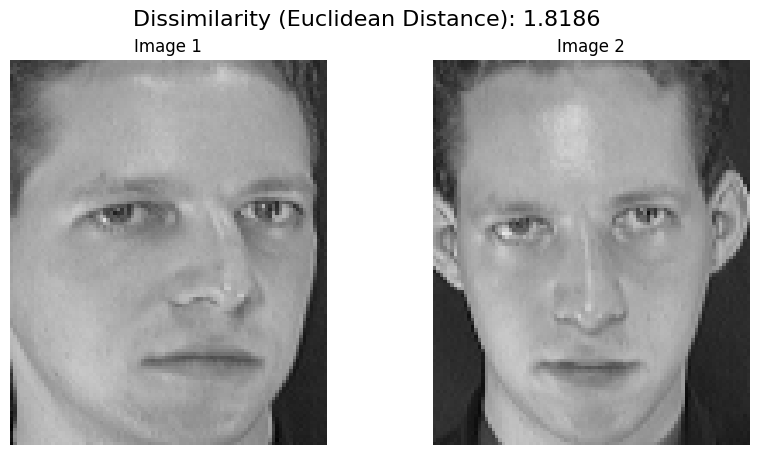

In [16]:
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

model = SiameseModel().to(device)
checkpoint = torch.load('Models/siamese_model_epoch_100.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

image_paths = [
    './data/faces/training/s1/2.pgm',
    './data/faces/training/s1/3.pgm'
]

images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
image_tensors = [transform(img).unsqueeze(0).to(device) for img in images]

with torch.no_grad():
    output1, output2 = model(image_tensors[0], image_tensors[1])
    euclidean_distance = F.pairwise_distance(output1, output2)
    distance = euclidean_distance.item()

threshold = 5  

if distance < threshold:
    print("The images are from the same person.")
else:
    print("The images are from different people.")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(images[0])
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(images[1])
axes[1].set_title("Image 2")
axes[1].axis('off')

fig.suptitle(f"Dissimilarity (Euclidean Distance): {distance:.4f}", fontsize=16)
plt.show()

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_8500\2826512944.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('Models/siamese_model_epoch_100.pt


Testing same person pairs:
Distance between s1/1.pgm and s1/2.pgm: 3.7501
Distance between s1/1.pgm and s1/3.pgm: 1.9391
Distance between s2/1.pgm and s2/2.pgm: 0.3531
Distance between s3/1.pgm and s3/2.pgm: 0.3457
Distance between s4/1.pgm and s4/2.pgm: 0.9221

Testing different person pairs:
Distance between s1/1.pgm and s2/1.pgm: 5.6923
Distance between s1/1.pgm and s3/1.pgm: 8.5125
Distance between s2/1.pgm and s4/1.pgm: 10.9319
Distance between s3/1.pgm and s8/1.pgm: 5.9340
Distance between s4/1.pgm and s8/1.pgm: 7.9463

Statistics:
Same person - Mean distance: 1.4620, Std: 1.2830
Different people - Mean distance: 7.8034, Std: 1.9111

Suggested threshold: 4.6327


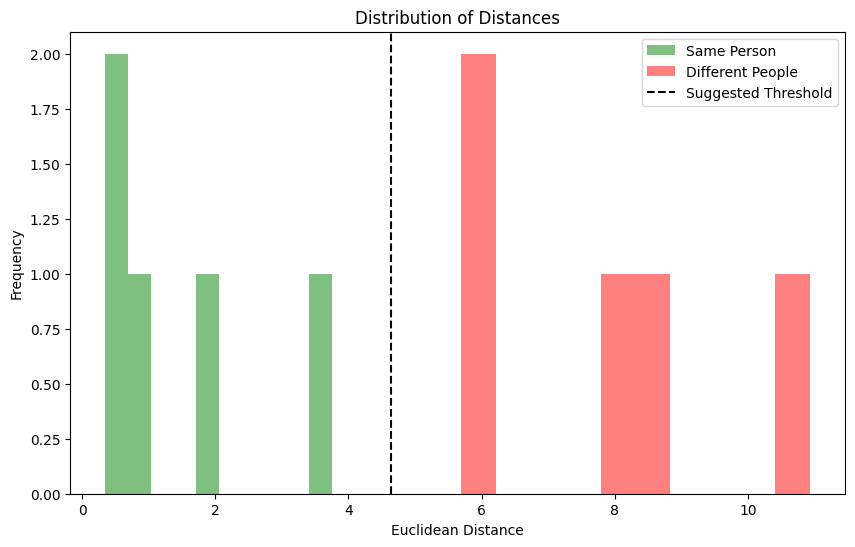

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

model = SiameseModel().to(device)
checkpoint = torch.load('Models/siamese_model_epoch_100.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def calculate_distance(img_path1, img_path2):
    images = [Image.open(path).convert('RGB') for path in [img_path1, img_path2]]
    image_tensors = [transform(img).unsqueeze(0).to(device) for img in images]
    
    with torch.no_grad():
        output1, output2 = model(image_tensors[0], image_tensors[1])
        distance = F.pairwise_distance(output1, output2).item()
    return distance, images

same_person_distances = []
base_path = './data/faces/training/'
same_person_pairs = [
    ('s1/1.pgm', 's1/2.pgm'),
    ('s1/1.pgm', 's1/3.pgm'),
    ('s2/1.pgm', 's2/2.pgm'),
    ('s3/1.pgm', 's3/2.pgm'),
    ('s4/1.pgm', 's4/2.pgm')
]

print("\nTesting same person pairs:")
for pair in same_person_pairs:
    path1 = os.path.join(base_path, pair[0])
    path2 = os.path.join(base_path, pair[1])
    distance, images = calculate_distance(path1, path2)
    same_person_distances.append(distance)
    print(f"Distance between {pair[0]} and {pair[1]}: {distance:.4f}")

different_person_distances = []
different_person_pairs = [
    ('s1/1.pgm', 's2/1.pgm'),
    ('s1/1.pgm', 's3/1.pgm'),
    ('s2/1.pgm', 's4/1.pgm'),
    ('s3/1.pgm', 's8/1.pgm'),
    ('s4/1.pgm', 's8/1.pgm')
]

print("\nTesting different person pairs:")
for pair in different_person_pairs:
    path1 = os.path.join(base_path, pair[0])
    path2 = os.path.join(base_path, pair[1])
    distance, images = calculate_distance(path1, path2)
    different_person_distances.append(distance)
    print(f"Distance between {pair[0]} and {pair[1]}: {distance:.4f}")

same_person_mean = np.mean(same_person_distances)
same_person_std = np.std(same_person_distances)
different_person_mean = np.mean(different_person_distances)
different_person_std = np.std(different_person_distances)

print("\nStatistics:")
print(f"Same person - Mean distance: {same_person_mean:.4f}, Std: {same_person_std:.4f}")
print(f"Different people - Mean distance: {different_person_mean:.4f}, Std: {different_person_std:.4f}")

suggested_threshold = (same_person_mean + different_person_mean) / 2
print(f"\nSuggested threshold: {suggested_threshold:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(same_person_distances, bins=10, alpha=0.5, label='Same Person', color='green')
plt.hist(different_person_distances, bins=10, alpha=0.5, label='Different People', color='red')
plt.axvline(x=suggested_threshold, color='black', linestyle='--', label='Suggested Threshold')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Distances')
plt.legend()
plt.show()

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_3168\110900658.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('Models/siamese_model_epoch_100.pth

The images are from the same person.


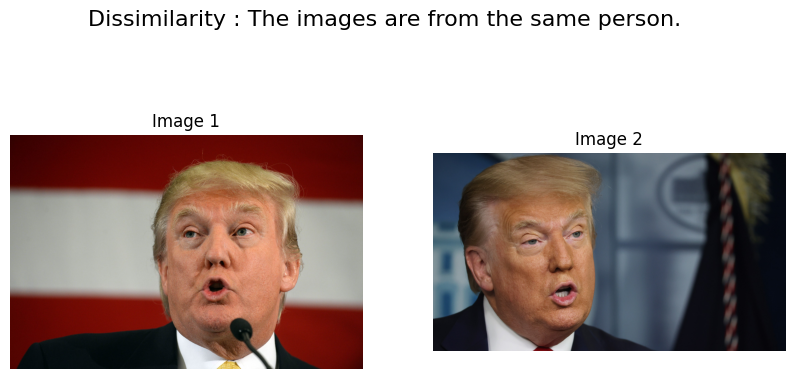

In [29]:
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

model = SiameseModel().to(device)
checkpoint = torch.load('Models/siamese_model_epoch_100.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

image_paths = [
    './testData/trump1.png',
    './testData/trump2.png'
]

images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
image_tensors = [transform(img).unsqueeze(0).to(device) for img in images]

with torch.no_grad():
    output1, output2 = model(image_tensors[0], image_tensors[1])
    euclidean_distance = F.pairwise_distance(output1, output2)
    distance = euclidean_distance.item()

threshold = 5  
title = ''

if distance < threshold:
    title = 'The images are from the same person.'
    print("The images are from the same person.")
else:
    title = 'The images are from different people.'
    print("The images are from different people.")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(images[0])
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(images[1])
axes[1].set_title("Image 2")
axes[1].axis('off')

fig.suptitle(f"Dissimilarity : {title}", fontsize=16)
plt.show()

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_3168\2777959097.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('Models/siamese_model_epoch_100.pt

The images are from different people.


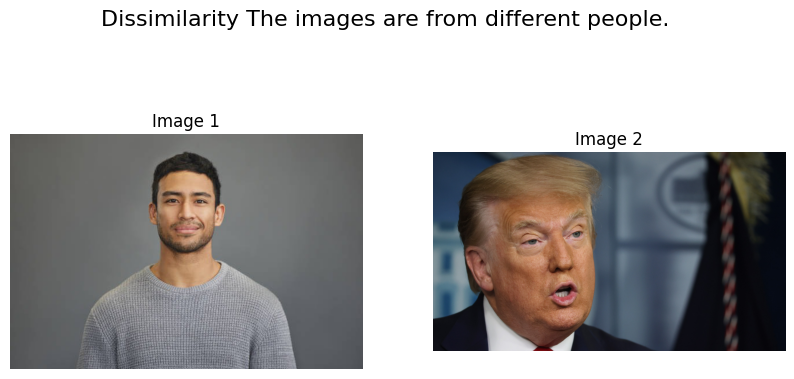

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

model = SiameseModel().to(device)
checkpoint = torch.load('Models/siamese_model_epoch_100.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

image_paths = [
    './testData/faces.jpg',
    './testData/trump2.png'
]

images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
image_tensors = [transform(img).unsqueeze(0).to(device) for img in images]

with torch.no_grad():
    output1, output2 = model(image_tensors[0], image_tensors[1])
    euclidean_distance = F.pairwise_distance(output1, output2)
    distance = euclidean_distance.item()

threshold = 5  
title = ''

if distance < threshold:
    title = 'The images are from the same person.'
    print("The images are from the same person.")
else:
    title = 'The images are from different people.'
    print("The images are from different people.")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(images[0])
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(images[1])
axes[1].set_title("Image 2")
axes[1].axis('off')

fig.suptitle(f"Dissimilarity : {title}", fontsize=16)
plt.show()